In [1]:
import tweepy
from tweepy import OAuthHandler
from tweepy import Cursor
from tweepy.streaming import StreamListener

import pandas as pd
import numpy as np

In [ ]:
#Pobranie i zapisanie danych (tweetów)

In [214]:
consumer_key =  'KJIHo2xjE9nVUfJONpif24pF3'
consumer_secret = '1AVv17FZEx8UaBXFG6egI5kRuqWcX80xNzShltXrdHlEIQcXTw'
access_token = '4763227235-YV76njbyoCLRI6DaE0pyLM3WpRIEppKYFrbTx8W'
access_secret = 'zhAzQdSOCrKrQast3RoCAWXvJk4A0nhinILT9OhxG1H2o'
 
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
 
api = tweepy.API(auth)

In [215]:
phiser_tweets = Cursor(api.search, q='pfizer', lang='en').items(200)

phiser_tweets_text  = [tweet.text for tweet in phiser_tweets]
    
phiser_tweets_text_df = pd.DataFrame(data=phiser_tweets_text, columns=['Text'])

In [16]:
phiser_tweets_text_df.to_csv(path_or_buf='/Users/marta/workspace/MED_2/pfiser_tweets_200.csv',index=False) #ustalić ścieżki

In [226]:
astra_tweets = Cursor(api.search, q='astrazeneca', lang='en').items(200)

astra_tweets_text  = [tweet.text for tweet in astra_tweets]
    
astra_tweets_text_df = pd.DataFrame(data=astra_tweets_text, columns=['Text'])

In [227]:
astra_tweets_text_df.to_csv(path_or_buf='/Users/marta/workspace/MED_2/astrazeneca_tweets_200.csv',index=False) #ustalić ścieżki

In [228]:
moderna_tweets = Cursor(api.search, q='moderna', lang='en').items(200)

moderna_tweets_text  = [tweet.text for tweet in moderna_tweets]
    
moderna_tweets_text_df = pd.DataFrame(data=moderna_tweets_text, columns=['Text'])

In [229]:
moderna_tweets_text_df.to_csv(path_or_buf='/Users/marta/workspace/MED_2/moderna_tweets_200.csv',index=False) #ustalić ścieżki

In [2]:
phiser_tweets_text_df = pd.read_csv('/Users/marta/workspace/MED_2/pfiser_tweets_200.csv') #ustalić ścieżki
astra_tweets_text_df = pd.read_csv('/Users/marta/workspace/MED_2/astrazeneca_tweets_200.csv') #ustalić ścieżki
moderna_tweets_text_df = pd.read_csv('/Users/marta/workspace/MED_2/moderna_tweets_200.csv') #ustalić ścieżki

In [231]:
#Czyszczenie tweetów

In [3]:
import emoji
import re
import string
import nltk

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize

In [4]:
def get_polish_stop_words():
    with open('/Users/marta/workspace/MED_2/TextMiningMED/gsp/data/stop_words_polish.txt', 'r') as f:
        words = f.read().splitlines() 
        return words

In [5]:
def strip_links(text):
    link_regex    = re.compile('((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL)
    links         = re.findall(link_regex, text)
    for link in links:
        text = text.replace(link[0], ', ')    
    return text

def strip_all_entities(text):
    entity_prefixes = ['@','#', '"']
    for separator in  string.punctuation:
        if separator not in entity_prefixes :
            text = text.replace(separator,' ')
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in entity_prefixes:
                words.append(word)
    return ' '.join(words)

def remove_punctuation(text):
        # Make translation table
        punct = string.punctuation
        trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
        return text.translate(trantab)

def remove_emojis(text):
    return emoji.get_emoji_regexp().sub(r'', text)

def remove_stopwords(text):
    stopwords_list = stopwords.words('english')
    stopwords_list.append("the")
    stopwords_list.append("rt")
    stopwords_list.append("pfizer")
    stopwords_list.append("astrazeneca")
    stopwords_list.append("moderna")
    #stopwords_list = get_polish_stop_words()
    stopwords_list.append("“")
    whitelist = ["n't", "not", "no"]
    words = text.split()
    clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1]
    return ' '.join(clean_words)

def stemming(text):
    porter = PorterStemmer()
    words = text.split()
    stemmed_words = [porter.stem(word) for word in words]
    return ' '.join(stemmed_words)

def lemmatization(text):
    lemmatizer = WordNetLemmatizer()
    words = text.split()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

def clean_text_round1(text):
    text = text.lower()
    text = strip_all_entities(strip_links(text))
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('#', '', text)
    text = remove_punctuation(text)
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = remove_emojis(text)
    text = remove_stopwords(text)
    text = stemming(text)
    text = lemmatization(text)
    return text

In [6]:
for i, row in phiser_tweets_text_df.iterrows():
    txt = clean_text_round1(row['Text'])
    phiser_tweets_text_df.at[i, 'Text'] = txt
    
for i, row in astra_tweets_text_df.iterrows():
    txt = clean_text_round1(row['Text'])
    astra_tweets_text_df.at[i, 'Text'] = txt
    
for i, row in moderna_tweets_text_df.iterrows():
    txt = clean_text_round1(row['Text'])
    moderna_tweets_text_df.at[i, 'Text'] = txt

In [7]:
text_phiser = phiser_tweets_text_df['Text'].to_string(index=False).replace('\\n', '').replace('\n', '')
text_phiser = clean_text_round1(text_phiser)
text_phiser = nltk.word_tokenize(text_phiser)
text_phiser = list(filter(lambda a: (a != '“' and a!='”' and a!='’'), text_phiser))
text_phiser = list(filter(lambda a: (len(a)>1), text_phiser))
text_phiser

['heard',
 'second',
 'dose',
 'az',
 'isn',
 'bad',
 'second',
 'dose',
 'heard',
 'cost',
 'per',
 'dose',
 'make',
 'covid',
 'vaccin',
 'sell',
 'to…break',
 'biontech',
 'covid',
 'vaccin',
 'store',
 'fridg',
 'tempera',
 'dose',
 'either',
 'az',
 'peopl',
 'develop',
 'antibodi',
 'covid',
 'do',
 'think',
 'time',
 'vaccin',
 'arriv',
 'given',
 'lower',
 'prioriti',
 'si',
 'evalu',
 'follow',
 'vaccin',
 'covid',
 'met',
 'necessari',
 'criteri',
 'vaccin',
 'store',
 'fridg',
 'longer',
 'eu',
 'drug',
 'regul',
 'say',
 'joh',
 'ok',
 'profit',
 'not',
 'scale',
 'place',
 'mani',
 'countri',
 'huge',
 'fin',
 'went',
 'get',
 'vaccin',
 'today',
 'nur',
 'refer',
 'chief',
 'support',
 'th…went',
 'get',
 'vaccin',
 'today',
 'nur',
 'refer',
 'chief',
 'support',
 'th…went',
 'get',
 'vaccin',
 'today',
 'nur',
 'refer',
 'chief',
 'support',
 'th…',
 'heard',
 'cost',
 'per',
 'dose',
 'make',
 'covid',
 'vaccin',
 'sell',
 'to…',
 'hello',
 'call',
 'visit',
 'nation',

In [8]:
text_astra = astra_tweets_text_df['Text'].to_string(index=False).replace('\\n', '').replace('\n', '')
text_astra = clean_text_round1(text_astra)
text_astra = nltk.word_tokenize(text_astra)
text_astra = list(filter(lambda a: (a != '“' and a!='”' and a!='’'), text_astra))
text_astra = list(filter(lambda a: (len(a)>1), text_astra))
text_astra

['china',
 'approv',
 'develop',
 'shenzhen',
 'kangtai',
 'biolog',
 'pr',
 'love',
 'see',
 'young',
 'malaysian',
 'share',
 'experi',
 'vaccin',
 'ti',
 'oh',
 'wow',
 'singl',
 'dose',
 'astrazeneca',
 'vaccin',
 'work',
 'fact',
 'oh',
 'wow',
 'singl',
 'dose',
 'astrazeneca',
 'vaccin',
 'work',
 'fact',
 'still',
 'not',
 'getlov',
 'see',
 'young',
 'malaysian',
 'share',
 'experi',
 'vaccin',
 'ti',
 'evalu',
 'follow',
 'vaccin',
 'covid',
 'met',
 'necessari',
 'criteri',
 'recent',
 'studi',
 'show',
 'singl',
 'dose',
 'astrazeneca',
 'vacci',
 'today',
 'tell',
 'intellectu',
 'properti',
 'rule',
 'drive',
 'globa',
 'recent',
 'studi',
 'show',
 'singl',
 'dose',
 'astrazeneca',
 'vacci',
 'oh',
 'wow',
 'singl',
 'dose',
 'astrazeneca',
 'vaccin',
 'work',
 'fact',
 'est',
 'sell',
 'price',
 'dose',
 'per',
 'dose',
 'first',
 'million',
 'dose',
 'train',
 'nur',
 'hospitali',
 'three',
 'blood',
 'clot',
 'vaccinnext',
 'opt',
 'open',
 'may',
 'avail',
 'selangor

In [9]:
text_moderna = moderna_tweets_text_df['Text'].to_string(index=False).replace('\\n', '').replace('\n', '')
text_moderna = clean_text_round1(text_moderna)
text_moderna = nltk.word_tokenize(text_moderna)
text_moderna = list(filter(lambda a: (a != '“' and a!='”' and a!='’'), text_moderna))
text_moderna = list(filter(lambda a: (len(a)>1), text_moderna))
text_moderna

['heard',
 'cost',
 'per',
 'dose',
 'make',
 'covid',
 'vaccin',
 'sell',
 'to…y',
 'think',
 'esp',
 'az',
 'due',
 'get',
 'though',
 'surgeri',
 'feb',
 'amp',
 'ye',
 'everyon',
 'wait',
 'lead',
 'believ',
 'better',
 'varian…',
 'heard',
 'cost',
 'per',
 'dose',
 'make',
 'covid',
 'vaccin',
 'sell',
 'to…vaccin',
 'effect',
 'indian',
 'variant',
 'studi',
 'lab',
 'base',
 'stu',
 'holi',
 'shit',
 'second',
 'shot',
 'awak',
 'worst',
 'chill',
 'ach',
 'est',
 'sell',
 'price',
 'dose',
 'per',
 'dose',
 'first',
 'million',
 'dose',
 'vaccin',
 'contain',
 'sm',
 'substanc',
 'suspect',
 'cau',
 'cancer',
 'est',
 'sell',
 'price',
 'dose',
 'per',
 'dose',
 'first',
 'million',
 'dose',
 'vaccin',
 'effect',
 'indian',
 'variant',
 'studi',
 'lab',
 'base',
 'stu',
 'vaccin',
 'effect',
 'indian',
 'variant',
 'studi',
 'lab',
 'base',
 'stu',
 'got',
 'appoint',
 'vaccin',
 'thursday',
 'finali',
 'announc',
 'we',
 'll',
 'also',
 'share',
 'author',
 'vaccin',
 'heard'

In [ ]:
#wizualizacja danych

In [239]:
import collections
import matplotlib.pyplot as plt

In [240]:
text_phiser_with_freq = collections.Counter(text_phiser)
text_phiser_with_freq.most_common(30)
phiser_df = pd.DataFrame(text_phiser_with_freq.most_common(40), columns = ['words', 'count'])
phiser_df.head()

,words,count
0,vaccin,63
1,not,32
2,month,26
3,covid,25
4,said,25


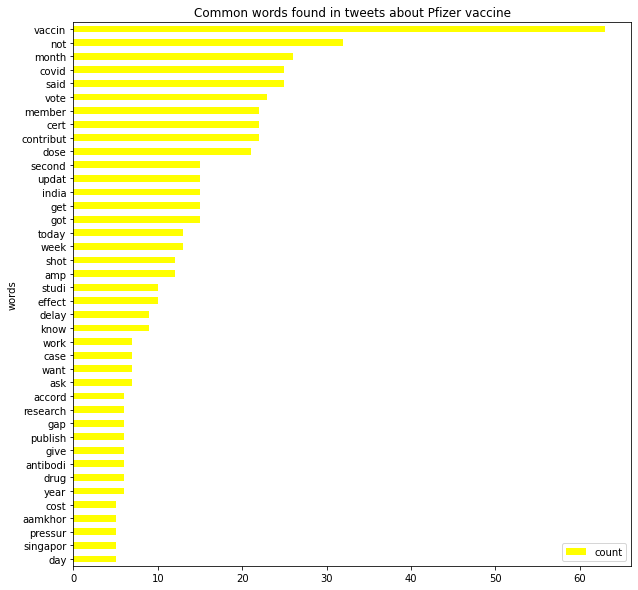

In [241]:
fig, ax = plt.subplots(figsize = (10,10))
phiser_df.sort_values(by='count').plot.barh(x='words',y='count',ax=ax, color='yellow')
ax.set_title('Common words found in tweets about Pfizer vaccine')
plt.show()

In [242]:
text_astra_with_freq = collections.Counter(text_astra)
text_astra_with_freq.most_common(30)
astra_df = pd.DataFrame(text_astra_with_freq.most_common(40), columns = ['words', 'count'])
astra_df.head()

,words,count
0,dose,87
1,announc,66
2,biden,60
3,million,53
4,vaccin,50


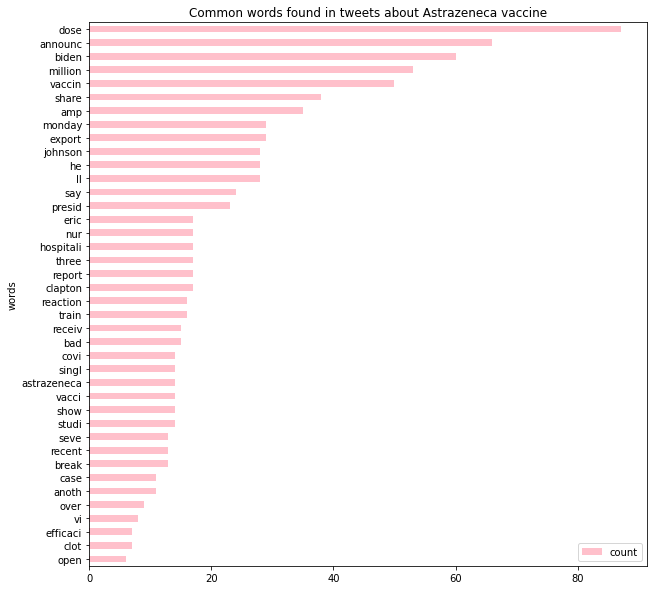

In [243]:
fig, ax = plt.subplots(figsize = (10,10))
astra_df.sort_values(by='count').plot.barh(x='words',y='count',ax=ax, color='pink')
ax.set_title('Common words found in tweets about Astrazeneca vaccine')
plt.show()

In [244]:
text_moderna_with_freq = collections.Counter(text_moderna)
text_moderna_with_freq.most_common(30)
moderna_df = pd.DataFrame(text_moderna_with_freq.most_common(40), columns = ['words', 'count'])
moderna_df.head()

,words,count
0,announc,85
1,dose,84
2,biden,72
3,vaccin,47
4,amp,43


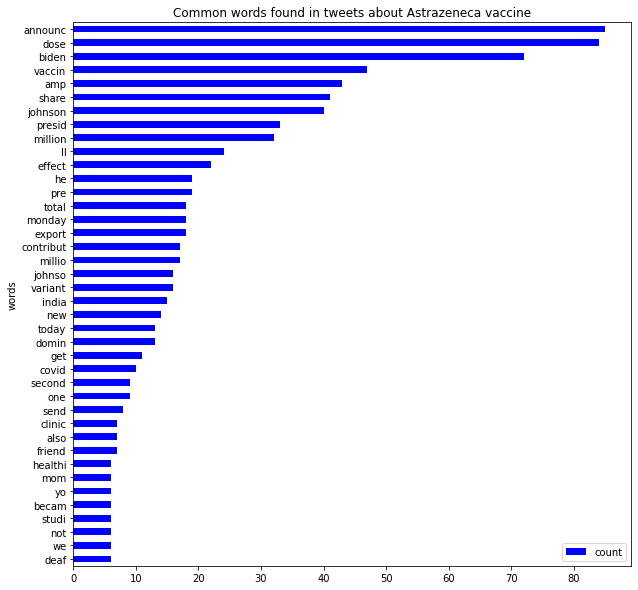

In [245]:
fig, ax = plt.subplots(figsize = (10,10))
moderna_df.sort_values(by='count').plot.barh(x='words',y='count',ax=ax, color='blue')
ax.set_title('Common words found in tweets about Astrazeneca vaccine')
plt.show()

In [246]:
import itertools

In [247]:
pfizer_terms_bigram = [list(nltk.bigrams(nltk.word_tokenize(tweet))) for tweet in phiser_tweets_text_df['Text']]
pfizer_terms_bigram = list(itertools.chain(*pfizer_terms_bigram))
pfizer_terms_bigram_counts = collections.Counter(pfizer_terms_bigram)
pfizer_terms_bigram_df = pd.DataFrame(pfizer_terms_bigram_counts.most_common(20), columns=['bigram', 'count'])
pfizer_terms_bigram_df

,bigram,count
0,"(updat, said)",22
1,"(said, month)",22
2,"(month, not)",22
3,"(not, contribut)",22
4,"(contribut, member)",22
5,"(member, vote)",22
6,"(vote, certifi)",22
7,"(certifi, the…)",22
8,"(covid, vaccin)",14
9,"(antibodi, respons)",11


In [248]:
astra_terms_bigram = [list(nltk.bigrams(nltk.word_tokenize(tweet))) for tweet in astra_tweets_text_df['Text']]
astra_terms_bigram = list(itertools.chain(*astra_terms_bigram))
astra_terms_bigram_counts = collections.Counter(astra_terms_bigram)
astra_terms_bigram_df = pd.DataFrame(astra_terms_bigram_counts.most_common(20), columns=['bigram', 'count'])
astra_terms_bigram_df

,bigram,count
0,"(biden, announc)",57
1,"(johnson, amp)",57
2,"(amp, johnson)",53
3,"(million, dose)",39
4,"(covid, vaccin)",30
5,"(dose, vaccin)",30
6,"(announc, monday)",29
7,"(dose, johnson)",28
8,"(monday, he)",28
9,"(he, ’)",28


In [249]:
moderna_terms_bigram = [list(nltk.bigrams(nltk.word_tokenize(tweet))) for tweet in moderna_tweets_text_df['Text']]
moderna_terms_bigram = list(itertools.chain(*moderna_terms_bigram))
moderna_terms_bigram_counts = collections.Counter(moderna_terms_bigram)
moderna_terms_bigram_df = pd.DataFrame(moderna_terms_bigram_counts.most_common(20), columns=['bigram', 'count'])
moderna_terms_bigram_df

,bigram,count
0,"(biden, announc)",75
1,"(johnson, amp)",63
2,"(amp, johnson)",60
3,"(dose, johnson)",41
4,"(presid, biden)",36
5,"(share, dose)",33
6,"(million, dose)",31
7,"(’, ll)",24
8,"(johnson, becom)",23
9,"(covid, vaccin)",23


In [250]:
from textblob import TextBlob

In [251]:
phiser_sentiment_objects = [TextBlob(tweet) for tweet in phiser_tweets_text_df['Text']]
phiser_sentiment_values = [[tweet.sentiment.polarity, str(tweet)] for tweet in phiser_sentiment_objects]
phiser_sentiment_df  = pd.DataFrame(phiser_sentiment_values, columns=['polarity', 'tweet'])
phiser_sentiment_df = phiser_sentiment_df[phiser_sentiment_df.polarity != 0]
phiser_sentiment_df.head()

,polarity,tweet
8,0.083333,delay second vaccin week significantli increas...
11,-0.125000,past year go public place groceri store wea…
12,0.017857,md could cri right small sampl comment u video...
17,0.400000,meantim let get austin fulli vaccin tell every...
18,0.136364,drug save live eli lilli drug save live jansse...


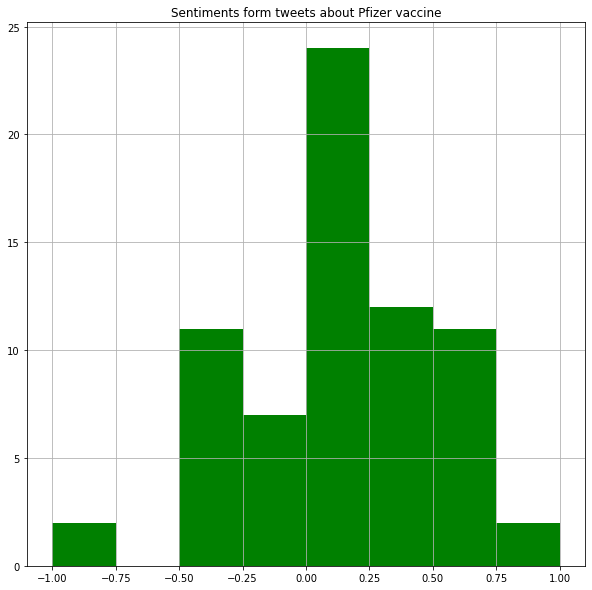

In [252]:
fig, ax = plt.subplots(figsize = (10,10))
phiser_sentiment_df.hist(bins=[-1, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1], ax=ax, color='green')
ax.set_title('Sentiments form tweets about Pfizer vaccine')
plt.show()

In [253]:
astra_sentiment_objects = [TextBlob(tweet) for tweet in astra_tweets_text_df['Text']]
astra_sentiment_values = [[tweet.sentiment.polarity, str(tweet)] for tweet in astra_sentiment_objects]
astra_sentiment_df  = pd.DataFrame(astra_sentiment_values, columns=['polarity', 'tweet'])
astra_sentiment_df = astra_sentiment_df[astra_sentiment_df.polarity != 0]
astra_sentiment_df.head()

,polarity,tweet
2,-0.750000,would tragic canada allow unus covid vaccin ex...
4,0.500000,say case share anoth million vaccin dose overs...
6,0.500000,say case share anoth million vaccin dose overs...
7,-0.083333,recent studi show singl dose astrazeneca’ vacc...
9,0.500000,say case share anoth million vaccin dose overs...


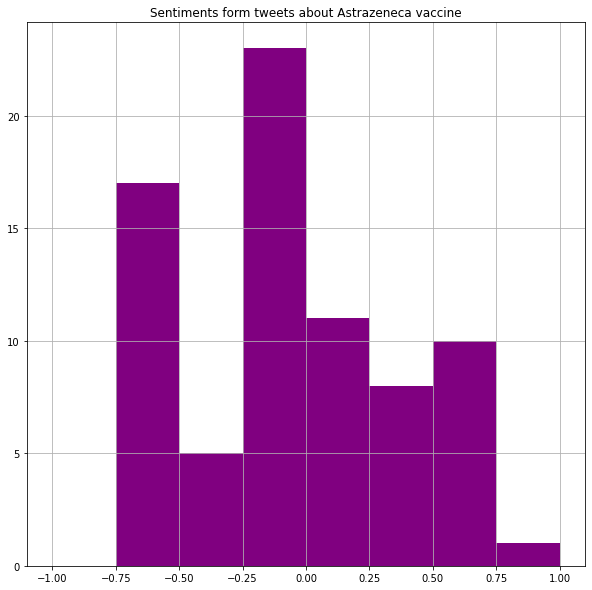

In [254]:
fig, ax = plt.subplots(figsize = (10,10))
astra_sentiment_df.hist(bins=[-1, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1], ax=ax, color='purple')
ax.set_title('Sentiments form tweets about Astrazeneca vaccine')
plt.show()

In [255]:
moderna_sentiment_objects = [TextBlob(tweet) for tweet in moderna_tweets_text_df['Text']]
moderna_sentiment_values = [[tweet.sentiment.polarity, str(tweet)] for tweet in moderna_sentiment_objects]
moderna_sentiment_df  = pd.DataFrame(moderna_sentiment_values, columns=['polarity', 'tweet'])
moderna_sentiment_df = moderna_sentiment_df[moderna_sentiment_df.polarity != 0]
moderna_sentiment_df.head()

,polarity,tweet
0,0.068182,new presid biden announc total contribut milli...
1,0.250000,qau first said go choic get vaccin pick choos ...
8,-0.100000,u share least million dose covid vaccin end ne...
14,0.500000,kideight nice good luck second dose wreck pret...
17,0.500000,make feel littl better still not go ditch mask...


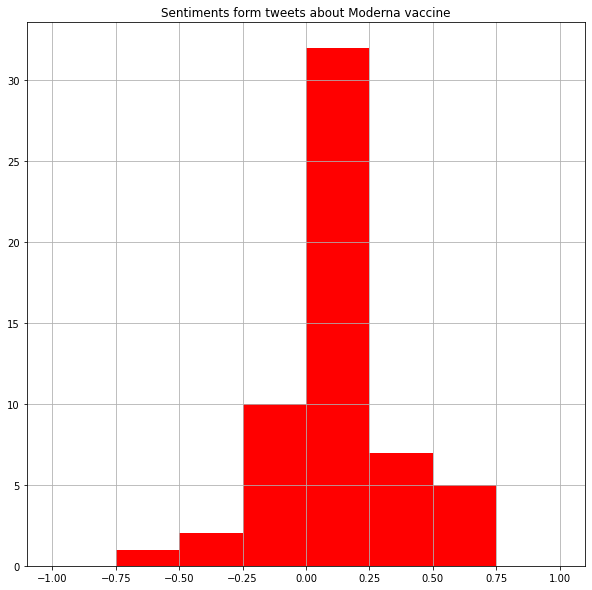

In [256]:
fig, ax = plt.subplots(figsize = (10,10))
moderna_sentiment_df.hist(bins=[-1, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1], ax=ax, color='red')
ax.set_title('Sentiments form tweets about Moderna vaccine')
plt.show()

In [ ]:
#wektoryzacja danych

In [10]:
import gensim

In [11]:
model_phiser = gensim.models.Word2Vec(sentences=[text_phiser], min_count=1)
model_astra = gensim.models.Word2Vec(sentences=[text_astra], min_count=1)
model_moderna = gensim.models.Word2Vec(sentences=[text_moderna], min_count=1)

In [12]:
model_phiser = gensim.models.Word2Vec(sentences=[text_phiser], min_count=1)
model_phiser.wv.most_similar('india', topn=3)

[('entir', 0.30544576048851013),
 ('vacci', 0.249688982963562),
 ('kat', 0.24022886157035828)]

In [13]:
phizer_dict = dict()
for index, word in enumerate(model_phiser.wv.index_to_key):
    #print(f"word #{index}/{len(model.wv.index_to_key)} is {word}")
    phizer_dict[word] = index
    
astra_dict = dict()
for index, word in enumerate(model_astra.wv.index_to_key):
    #print(f"word #{index}/{len(model.wv.index_to_key)} is {word}")
    astra_dict[word] = index
    
moderna_dict = dict()
for index, word in enumerate(model_moderna.wv.index_to_key):
    #print(f"word #{index}/{len(model.wv.index_to_key)} is {word}")
    moderna_dict[word] = index

In [14]:
phizer_dict

{'vaccin': 0,
 'dose': 1,
 'get': 2,
 'today': 3,
 'nur': 4,
 'refer': 5,
 'chief': 6,
 'support': 7,
 'covid': 8,
 'sell': 9,
 'per': 10,
 'make': 11,
 'heard': 12,
 'cost': 13,
 'went': 14,
 'work': 15,
 'singl': 16,
 'astrazeneca': 17,
 'wow': 18,
 'fact': 19,
 'th…': 20,
 'th…went': 21,
 'peopl': 22,
 'effect': 23,
 'az': 24,
 'variant': 25,
 'million': 26,
 'base': 27,
 'studi': 28,
 'indian': 29,
 'lab': 30,
 'oh': 31,
 'stu': 32,
 'antibodi': 33,
 'do': 34,
 'develop': 35,
 'either': 36,
 'store': 37,
 'to…': 38,
 'got': 39,
 'fridg': 40,
 'amp': 41,
 'first': 42,
 'jab': 43,
 'old': 44,
 'tempera': 45,
 'friend': 46,
 'to…went': 47,
 'biontech': 48,
 'one': 49,
 'book': 50,
 'year': 51,
 'morrison': 52,
 'price': 53,
 'document': 54,
 'pfizer': 55,
 'th…vaccin': 56,
 'go': 57,
 'true': 58,
 'mani': 59,
 'warn': 60,
 'know': 61,
 'said': 62,
 'like': 63,
 'notic': 64,
 'entir': 65,
 'not': 66,
 'th…oh': 67,
 'est': 68,
 'it': 69,
 'shot': 70,
 'announc': 71,
 'say': 72,
 'feel':

In [15]:
#zapisanie danych w formacie czytelnym dla programu gsp

In [16]:
import random

In [19]:
tweets_phizer = ''

n_tweets = 50#len(phiser_tweets_text_df)

idx = 0
r = random.randint(3, 8)
for index, row in phiser_tweets_text_df.iterrows():
    #print('row no: ', index)
    #print('no itemsets:', r)
    tweet = row['Text']
    tweet = nltk.word_tokenize(tweet)
    #print(tweet)
    for i in tweet:
        tweet_as_number = phizer_dict.get(i)
        if tweet_as_number != None:
            tweets_phizer += str(tweet_as_number) + ' '
    tweets_phizer += str(-1) + ' '
    idx=idx+1
    if idx > r:
        tweets_phizer +=str(-2)+'\n'
        idx = 0
        r = random.randint(3, 8)
        #print('end of a sequence (row no:', index, ')')
        #print(tweets_phizer)
    
    if index>n_tweets:
        #print(':) end', index)
        break

tweets_phizer +=str(-2)+ '\n'

file = open("/Users/marta/workspace/MED_2/TextMiningMED/gsp/data/pfizer_tweets_"+str(n_tweets)+".txt","w")
file.writelines(tweets_phizer)
file.close()

In [20]:
tweets_phizer

'12 96 1 24 223 76 96 1 85 357 -1 12 13 10 1 11 8 0 9 38 -1 87 48 8 0 37 40 367 72 -1 1 36 24 22 35 33 8 1 22 35 -1 199 80 0 201 104 196 195 -1 232 109 0 8 108 121 -1 -2\n0 37 40 173 147 166 112 72 -1 159 234 66 151 129 59 127 154 -1 14 2 0 3 5 6 7 20 -1 14 2 0 3 5 6 7 20 -1 14 2 0 3 5 6 7 20 -1 12 13 10 1 11 8 0 9 38 -1 141 117 143 145 50 213 214 -1 -2\n31 18 16 1 17 0 15 19 366 1 55 -1 12 13 10 1 11 8 0 9 38 -1 179 127 0 181 183 185 -1 58 107 62 0 122 22 -1 -2\n68 9 53 1 10 1 42 26 1 10 1 -1 197 198 200 202 203 146 81 106 146 -1 14 2 0 3 5 6 7 20 -1 0 23 29 25 28 30 27 28 -1 193 81 52 71 26 0 1 -1 190 177 70 -1 2 187 186 70 104 184 15 66 195 82 -1 14 2 0 3 5 6 7 20 -1 -2\n182 180 61 178 204 62 191 2 70 -1 221 1 3 78 64 59 22 3 -1 51 44 79 230 229 228 83 226 -1 224 41 222 207 219 218 59 -1 1 36 24 22 35 33 8 1 22 35 -1 216 215 46 63 212 46 84 63 379 -1 12 13 10 1 11 8 0 9 38 -1 66 210 175 208 49 1 206 -1 12 13 10 1 11 8 0 9 38 -1 -2\n28 171 174 131 132 137 140 142 8 208 16 1 24 -1 52 

In [21]:
file = open("/Users/marta/workspace/MED_2/TextMiningMED/gsp/data/pfizer_tweets_"+str(n_tweets)+".txt","w")
file.writelines(tweets_phizer)
file.close()

In [22]:
tweets_astra = ''

n_tweets = 50#len(astra_tweets_text_df)

idx = 0
r = random.randint(3, 8)
for index, row in astra_tweets_text_df.iterrows():
    #print('row no: ', index)
    #print('no itemsets:', r)
    tweet = row['Text']
    tweet = nltk.word_tokenize(tweet)
    #print(tweet)
    for i in tweet:
        tweet_as_number = astra_dict.get(i)
        if tweet_as_number != None:
            tweets_astra += str(tweet_as_number) + ' '
    tweets_astra += str(-1) + ' '
    idx=idx+1
    if idx > r:
        tweets_astra +=str(-2)+'\n'
        idx = 0
        r = random.randint(3, 8)
        #print('end of a sequence (row no:', index, ')')
        #print(tweets_astra)
    
    if index>n_tweets:
        #print(':) end', index)
        break

tweets_astra +=str(-2)+ '\n'

In [23]:
tweets_astra

'328 150 46 149 148 147 -1 20 13 15 17 14 12 1 183 -1 7 6 3 0 2 1 5 4 318 73 0 -1 7 6 3 0 2 1 5 4 318 73 0 -1 145 35 -1 -2\n20 13 15 17 14 12 1 183 -1 85 69 1 25 86 87 -1 11 8 9 3 0 2 1 226 -1 89 143 142 141 140 139 310 1 -1 11 8 9 3 0 2 1 226 -1 -2\n7 6 3 0 2 1 5 4 318 73 0 -1 43 40 36 0 39 0 33 28 0 39 0 -1 22 23 19 1 -1 153 96 54 94 95 84 97 104 50 -1 136 50 135 98 103 151 133 -1 47 51 53 55 57 1 -1 70 49 52 42 31 25 1 2 37 288 -1 154 35 171 170 169 38 0 47 -1 -2\n20 13 15 17 14 12 1 183 -1 43 40 36 0 39 0 33 28 0 39 0 -1 7 6 3 0 2 1 5 4 318 73 0 -1 32 26 30 29 27 12 34 25 1 -1 43 40 36 0 39 0 33 28 0 39 0 -1 168 74 68 167 23 19 69 1 -1 -2\n92 44 45 58 64 0 50 -1 61 -1 20 13 15 17 14 12 1 183 -1 164 163 162 161 160 159 158 -1 85 69 1 25 86 87 -1 -2\n72 157 156 50 71 65 28 155 0 -1 11 8 9 3 0 2 1 226 -1 32 26 30 29 27 12 34 25 1 -1 43 40 36 0 39 0 33 28 0 39 0 -1 153 96 54 94 95 84 97 104 50 -1 70 49 52 42 31 25 1 2 37 288 -1 132 33 126 130 98 108 111 0 -1 -2\n11 8 9 3 0 2 1 226 -1 2

In [24]:
file = open("/Users/marta/workspace/MED_2/TextMiningMED/gsp/data/astra_tweets_"+str(n_tweets)+".txt","w")
file.writelines(tweets_astra)
file.close()

In [25]:
tweets_moderna = ''

n_tweets = 50#len(moderna_tweets_text_df)

idx = 0
r = random.randint(3, 8)
for index, row in moderna_tweets_text_df.iterrows():
    #print('row no: ', index)
    #print('no itemsets:', r)
    tweet = row['Text']
    tweet = nltk.word_tokenize(tweet)
    #print(tweet)
    for i in tweet:
        tweet_as_number = moderna_dict.get(i)
        if tweet_as_number != None:
            tweets_moderna += str(tweet_as_number) + ' '
    tweets_moderna += str(-1) + ' '
    idx=idx+1
    if idx > r:
        tweets_moderna +=str(-2)+'\n'
        idx = 0
        r = random.randint(3, 8)
        #print('end of a sequence (row no:', index, ')')
        #print(tweets_moderna)
    
    if index>n_tweets:
        #print(':) end', index)
        break

tweets_moderna +=str(-2)+ '\n'

In [26]:
tweets_moderna

'6 7 4 0 5 2 1 3 15 -1 105 145 149 107 151 106 126 136 122 31 -1 105 125 133 159 157 182 183 -1 6 7 4 0 5 2 1 3 15 -1 1 8 10 9 11 14 13 11 -1 -2\n184 161 100 67 95 166 167 168 -1 39 3 29 0 4 0 26 23 0 4 0 -1 1 169 171 172 173 175 -1 39 3 29 0 4 0 26 23 0 4 0 -1 1 8 10 9 11 14 13 11 -1 1 8 10 9 11 14 13 11 -1 41 92 1 181 -1 25 111 48 112 37 176 1 0 263 31 263 -1 6 7 4 0 5 2 1 3 15 -1 -2\n6 7 4 0 5 2 1 3 15 -1 160 52 1 2 110 115 -1 6 7 4 0 5 2 1 3 15 -1 6 7 4 0 5 2 1 3 15 -1 39 3 29 0 4 0 26 23 0 4 0 -1 -2\n22 16 20 21 19 0 257 -1 1 8 10 9 11 14 13 11 -1 91 83 67 -1 31 155 192 193 194 162 -1 6 7 4 0 5 2 1 3 15 -1 -2\n6 7 4 0 5 2 1 3 15 -1 44 28 1 32 33 34 31 -1 39 3 29 0 4 0 26 23 0 4 0 -1 22 16 20 21 19 0 257 -1 1 8 10 9 11 14 13 11 -1 47 42 37 36 23 0 1 23 31 -1 88 40 85 79 16 74 170 -1 39 3 29 0 4 0 26 23 0 4 0 -1 -2\n6 7 4 0 5 2 1 3 15 -1 38 27 25 66 43 0 206 263 31 263 -1 160 52 1 2 110 115 -1 6 7 4 0 5 2 1 3 15 -1 39 3 29 0 4 0 26 23 0 4 0 -1 1 8 10 9 11 14 13 11 -1 1 8 10 9 11 14 

In [27]:
file = open("/Users/marta/workspace/MED_2/TextMiningMED/gsp/data/moderna_tweets_"+str(n_tweets)+".txt","w")
file.writelines(tweets_moderna)
file.close()

In [28]:
#konwersja zbioru częstych sekwencji na słowa (po uruchomieniu GSP)

In [88]:
gsp_results_pfizer_df = pd.read_csv('/Users/marta/workspace/MED_2//TextMiningMED/gsp/experiments/gsp_results_pfizer.csv')

In [89]:
gsp_results_pfizer_df

,Seq,Sup
0,"[[1], [0, 1, 8, 9, 10, 11, 12, 13, 38], [0]]",4


In [90]:
result_sequences_as_words_pfizer = []

for index, row in gsp_results_pfizer_df.iterrows():
    #print(row['Seq'])
    result_seq = nltk.word_tokenize((row['Seq']))
    del result_seq[0]; del result_seq[-1]
    result_seq_as_words = []
    for l in result_seq:
        if l == '[':
            result_itemset_as_words = []
            continue
        if l == ']':
            result_seq_as_words.append(result_itemset_as_words)
            continue
        if l == ',':
            #result_seq.remove(l)
            continue
        result_itemset_as_words.append(list(phizer_dict.keys())[list(phizer_dict.values()).index(int(l, base=10))])
    
    result_sequences_as_words_pfizer.append(result_seq_as_words)

data =[]
for m in result_sequences_as_words_pfizer:
    data.append(m)
data_df = pd.DataFrame(data)
data_df

,0,1,2
0,[dose],"[vaccin, dose, covid, sell, per, make, heard, ...",[vaccin]


In [104]:
pfizer_results = data_df.values.tolist()
pfizer_results

[[['dose'],
  ['vaccin', 'dose', 'covid', 'sell', 'per', 'make', 'heard', 'cost', 'to…'],
  ['vaccin']]]

In [115]:
from graphviz import Digraph

colors = ['green','red', 'pink', 'yellow', 'orange', 'brown', 'purple'] #edge colors

class Visualise:

    def _generate_dot_nodes(self, dot):
        unique_nodes = set()
        for dependency in self.data:
            for itemset in dependency:
                itemset_str = ''
                it = 0
                for i in itemset:
                    itemset_str+=i
                    if it != len(itemset)-1:
                        itemset_str+=','
                    it+=1
                unique_nodes.add(itemset_str)

        for id, val in enumerate(unique_nodes):
            attr_num = self._get_number_of_elements_in_set(val)
            with dot.subgraph(name='cluster' + str(attr_num)) as c:
                c.attr(fillcolor='blue:cyan', label='acluster', fontcolor='white',style='filled', gradientangle='270')
                c.attr('node', shape='box', fillcolor='red:yellow',style='filled', gradientangle='90')
                c.node(val, val)
                c.attr(label='Zbiory elementów o liczności ' + str(attr_num))

    def _get_number_of_elements_in_set(self, attr_set):
        return attr_set.count(',') + 1 if attr_set else 0

    def _add_dot_edges(self, dot):
        itemsets_str = {}
        it = 0
        for dependency in self.data:
            itemsets_str[it] = []
            for itemset in dependency:
                itemset_str = ''
                it2 = 0
                for i in itemset:
                    itemset_str+=i
                    if it2 != len(itemset)-1:
                        itemset_str+=','
                    it2+=1
            
                itemsets_str[it].append(itemset_str)
        it+=1
        
        for idx in range(len(itemsets_str)):
            for j in range(len(itemsets_str[idx])):
                if j!= len(itemsets_str[idx])-1:
                    try:
                        dot.edge(itemsets_str[idx][j], itemsets_str[idx][j+1], color=colors[idx])
                    except:
                        dot.edge(itemsets_str[idx][j], itemsets_str[idx][j+1], color=colors[0])
    
    def draw(self, path, title):
        dot = Digraph(comment='Wizualizacja zbiorów częstych')
        dot.attr(label=title)
        dot.attr(fontsize='20')
        itemset_str = self._generate_dot_nodes(dot)
        self._add_dot_edges(dot)
        dot.render(path, view=True)

    def __init__(self, data):
        self.data = data

In [116]:
visualiser = Visualise(pfizer_results)
visualiser.draw('/Users/marta/workspace/MED_2/TextMiningMED/gsp/experiments/pfiser_visualisation.gv', r'\n\nCzęste sekwencje odnalezione w tweetach zawierajacych hashtag PFISER za pomocą GSP (sup 0.5)')

In [117]:
gsp_results_astra_df = pd.read_csv('/Users/marta/workspace/MED_2//TextMiningMED/gsp/experiments/gsp_results_astra.csv')

In [118]:
result_sequences_as_words_astra = []

for index, row in gsp_results_astra_df.iterrows():
    #print(row['Seq'])
    result_seq = nltk.word_tokenize((row['Seq']))
    del result_seq[0]; del result_seq[-1]
    result_seq_as_words = []
    for l in result_seq:
        if l == '[':
            result_itemset_as_words = []
            continue
        if l == ']':
            result_seq_as_words.append(result_itemset_as_words)
            continue
        if l == ',':
            #result_seq.remove(l)
            continue
        result_itemset_as_words.append(list(astra_dict.keys())[list(astra_dict.values()).index(int(l, base=10))])
    
    result_sequences_as_words_astra.append(result_seq_as_words)
    
data =[]
for m in result_sequences_as_words_astra:
    data.append(m)
data_df = pd.DataFrame(data)
data_df

,0,1,2
0,"[dose, vaccin, astrazeneca, singl, fact, work,...",[dose],"[clot, blood]"


In [119]:
astra_results = data_df.values.tolist()
astra_results

[[['dose',
   'vaccin',
   'astrazeneca',
   'singl',
   'fact',
   'work',
   'wow',
   'oh',
   'two',
   'better'],
  ['dose'],
  ['clot', 'blood']]]

In [120]:
visualiser = Visualise(astra_results)
visualiser.draw('/Users/marta/workspace/MED_2/TextMiningMED/gsp/experiments/astra_visualisation.gv', r'\n\nCzęste sekwencje odnalezione w tweetach zawierajacych hashtag ASTRAZENECA za pomocą GSP (sup 0.5)')

In [123]:
gsp_results_moderna_df = pd.read_csv('/Users/marta/workspace/MED_2//TextMiningMED/gsp/experiments/gsp_results_moderna.csv')

In [124]:
result_sequences_as_words_moderna = []

for index, row in gsp_results_moderna_df.iterrows():
    #print(row['Seq'])
    result_seq = nltk.word_tokenize((row['Seq']))
    del result_seq[0]; del result_seq[-1]
    result_seq_as_words = []
    for l in result_seq:
        if l == '[':
            result_itemset_as_words = []
            continue
        if l == ']':
            result_seq_as_words.append(result_itemset_as_words)
            continue
        if l == ',':
            #result_seq.remove(l)
            continue
        result_itemset_as_words.append(list(moderna_dict.keys())[list(moderna_dict.values()).index(int(l, base=10))])
    
    result_sequences_as_words_moderna.append(result_seq_as_words)
    
data =[]
for m in result_sequences_as_words_moderna:
    data.append(m)
data_df = pd.DataFrame(data)
data_df

,0,1
0,"[vaccin, effect, variant, indian, studi, base,...","[dose, vaccin, covid, sell, per, make, heard, ..."


In [125]:
moderna_results = data_df.values.tolist()
moderna_results

[[['vaccin', 'effect', 'variant', 'indian', 'studi', 'base', 'lab'],
  ['dose', 'vaccin', 'covid', 'sell', 'per', 'make', 'heard', 'cost', 'to…']]]

In [126]:
visualiser = Visualise(moderna_results)
visualiser.draw('/Users/marta/workspace/MED_2/TextMiningMED/gsp/experiments/moderna_visualisation.gv', r'\n\nCzęste sekwencje odnalezione w tweetach zawierajacych hashtag MODERNA za pomocą GSP (sup 0.5)')